<h1> Response matrix analysis </h1>

<h2> Dependencies </h2>

<h3> External module dependencies </h3>

In [1]:
import matplotlib.pyplot as plt
%pylab inline
import pandas as pd
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import datetime
import pprint
import os.path

Populating the interactive namespace from numpy and matplotlib


Mayavi is faster in plotting 3D data.
But the x3d interface to the notebook does not allow for scaling

In [ ]:
from mayavi import mlab
mlab.init_notebook()

<h3> Internal module dependencies </h3>

Modules in development at HZB

In [2]:
bact2_path = os.path.join(os.getcwd(), *([os.path.pardir]*3))
bact2_path = os.path.normpath(bact2_path)
bact2_path

'/home/mfp/Devel/github/bact2'

In [3]:
import os.path
import sys
import importlib

pierres_dir = '/net/nfs/srv/MachinePhysics/MachineDevelopment/schnizer/github/'
if pierres_dir not in sys.path:
    sys.path.append(pierres_dir)

if bact2_path not in sys.path:
    sys.path.append(bact2_path)
    
import bact2.pandas.dataframe.df_aggregate as dfg
importlib.reload(dfg)

from bact2.applib.utils import steerer as st_u, utils as m_u
from bact2.applib.response_matrix import bpm_data as bd
importlib.reload(st_u)
importlib.reload(m_u)
importlib.reload(bd)


import bact2.pandas.dataframe.df_aggregate as dfg
importlib.reload(dfg)

from bact2.applib.utils import steerer as st_u, utils as m_u
from bact2.applib.response_matrix import bpm_data as bd, bpm_plots as bp

importlib.reload(st_u)
importlib.reload(m_u)
importlib.reload(bd)
importlib.reload(bp)

<module 'bact2.applib.response_matrix.bpm_plots' from '/home/mfp/Devel/github/bact2/bact2/applib/response_matrix/bpm_plots.py'>

<h2> Loading measured data </h2>

Currently there are two ways to access the measurement data:
    
    * Accessing the data from the mongodb installed at HZB
    * loading the data from a json exported file.
    
The flag below is set if data are loaded from a json file

Please note: loading the file requires a significant amount ouf time

In [4]:
use_json = True

In [5]:
if not use_json:
    from databroker import Broker
    db = Broker.named('light')
    uid = '78f148ec-4f55-44c8-bde4-e389ea6ec4d3'
    uid = 'ee52c929-4d97-4838-b007-517beb58cba7'
    uid = '02fe5d1c-b012-4054-8e53-77c911b97e3b'
    uid = '75c454ca-bda5-4254-b7af-0acf365e989d'
    r = db(plan_name='response_matrix')
    cnt = 0
    for doc in r:
        start = doc['start']
        d = datetime.datetime.fromtimestamp(start['time'])
        print(d, start['uid'])

In [6]:
# First full run 
uid = '5af3a89f-c496-4d3d-84fd-1ca76c9331dc'
# second full run 


In [7]:
if not use_json:
    header = db[uid]

In [8]:
path = '/opt/OPI/MachinePhysics/MeasurementData/Users/schnizer/response_matrix'
path = os.getcwd()
path = os.path.join(path, *([os.path.pardir]*4 + ['data', 'response_matrix']) )
path = os.path.normpath(path)
                    
path

'/home/mfp/Devel/github/data/response_matrix'

In [9]:
pickle_name = os.path.join(path, 'response_measurement.json.bz2')
pickle_name

'/home/mfp/Devel/github/data/response_matrix/response_measurement.json.bz2'

In [10]:
if use_json:
    start_stamp = datetime.datetime.now()
    t_table = pd.read_json(pickle_name)
    read_in = datetime.datetime.now()
    t_table = t_table.infer_objects().sort_index()
    nt = dfg.df_vectors_convert(t_table, copy=False)
    now = datetime.datetime.now()
    t_table = nt
    del nt
    dt_read = read_in - start_stamp
    dt_conv = now - read_in
    dt = now - start_stamp
    fmt = 'Reading data for json required {}; data conversion required {}; total {}'
    print(fmt.format(dt_read, dt_conv, dt))
else:
    t_table = header.table()
    t_table.tail()

Reading data for json required 0:00:05.112748; data conversion required 0:00:01.577295; total 0:00:06.690043


If data was loaded from a json file the numpy arrays were exported as lists.
This conversion has to be reverted; otherwise the processing of the data frame
further down will fail.

In [11]:
nt = dfg.df_vectors_convert(t_table, copy=False)
t_table = nt

In [12]:
t_table.time.max()

1578454481837

Fix data if imported as json file

In [13]:
if use_json:
    t_table = t_table.infer_objects().sort_index()
    

In [14]:
cols_to_process = [
    'time',
    'sc_selected',
    'bpm_x_ref', 'bpm_y_ref',
    'bpm_x_diff', 'bpm_y_diff',
    'bk_dev_mode', 
    'steerer_mode',
    'steerer_pos',
    'measurement',
    'I_rounded',
    'bk_dev_dI', 'bk_dev_scale_factor', 'bk_dev_current_offset', 
    'sc_sel_dev_setpoint', 'sc_sel_dev_readback',
    'ramp_index',
    'bpm_waveform_x_pos', 'bpm_waveform_y_pos', 
    'bpm_waveform_ds',
    'dt',
    'bpm_x_scale', 'bpm_y_scale',
    'steerer_type',
    'relative_step',
    'bpm_waveform_names'
]

In [15]:
t_table;

<h2> Trying to understand the data </h2>

<h3> Adding information which was not stored in the measurememnt .</h3>

The following two currents are the currents which are the default ones found in 
AT for sstandard BESSY Mode

In [16]:
start_current_horizontal = 0.07 / 6
start_current_vertical = 0.07

Adding additional imformations

These shall be added by the book keeping device in furture

**Todo**:

   * add a measurement number: an consecutive integer running up for measurement by measurement 
   * steerer_pos: the position of the steerer within the machine Heere it is also used for sorting 
       e.g. in the  following manner:  ignoring that BESSY II lost its symmetry one groups steerers together 
       which are at the same position within a cell or supercell
    


In [17]:
table_sel = t_table.reindex(columns=cols_to_process, index=t_table.index)
table_sel.loc[:,'I_rounded'] = m_u.round_float_values(table_sel.sc_sel_dev_setpoint)
table_sel.loc[:, 'measurement'] = -1
table_sel.loc[:, 'steerer_pos'] = -1
table_sel.loc[:, 'ramp_index'] = -1
table_sel = st_u.add_steerer_info(table_sel, copy=False)
table_sel = st_u.add_relative_steps(table_sel, 
                               horizontal_current=start_current_horizontal,
                               vertical_current=start_current_vertical,
                               copy=False)
table_sel = table_sel.infer_objects()

In [18]:
# tt = m_u.add_measurement_counts(table_sel)
dfg.logger.setLevel('DEBUG')
tt = m_u.add_measurement_counts(table_sel)
tt.loc[:, 'measurement'] = pd.to_numeric(tt.measurement)
table_agg = dfg.df_with_vectors_mean_skip_first(tt.infer_objects())
# assert(tt.shape[0]/table_agg.shape[0]==3)



In [19]:
def provide_steerer_sort(df):
    tmp = [st_u.SteererSort(*tup) for tup in zip(df.sc_selected, df.index)]
    tmp.sort()
    counter = m_u.Counter()
    for t in tmp:
        t.count = counter(t.name)
    return tmp


<h3> Checking measurement index step by step</h3>

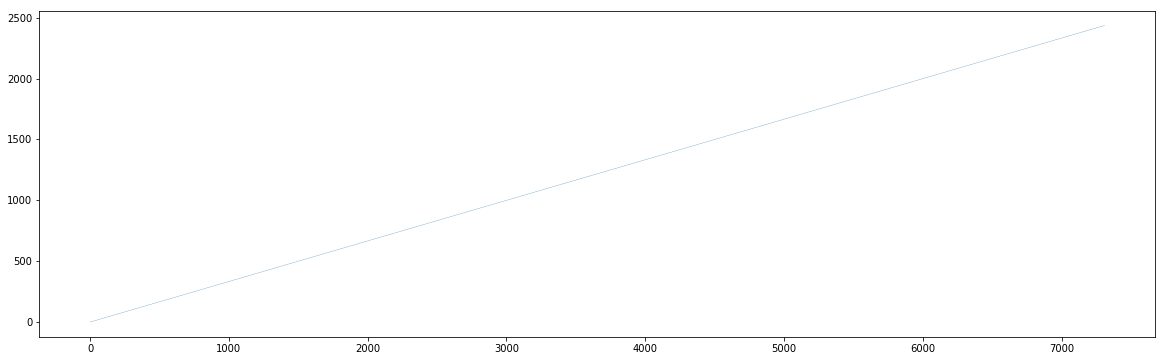

In [20]:
plt.figure(figsize=[20,6])
plt.plot(tt.index, tt.measurement, linewidth=.25)
#pd.DataFrame.groupby?

<h3> First tries to plot the response matrix </h3>

For further data evaluation a linear fit is made to all the steerer measurements. Furthermmore the 
offset of the measurements from the fit are added.

These are made using the functions:
   * :func:`bd.calc_bpm_gains` calculates (an unbiased?) linear fit
   * :func:`bd.calc_bpm_diff` calculates the offste of the measurement from the fit
   
   

In [22]:

table_meas = table_agg.loc[table_agg.bk_dev_mode == 'store_data',:].infer_objects()

# Reduce to minimal range
# table_meas = table_meas.loc[table_meas.relative_step.abs()<0.3,:]

table_meas = m_u.add_measurement_index(table_meas)
meas_ref = bd.calc_bpm_gains(table_meas)#.infer_objects()
table_meas_w_ref = bd.calc_bpm_ref(table_meas, meas_ref)

<h3> Checking if the stored scaling is correct </h3>

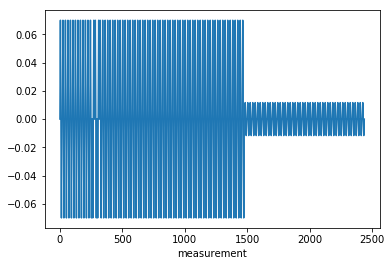

In [23]:
(table_meas_w_ref.bk_dev_dI/table_meas_w_ref.bk_dev_scale_factor).plot()

<h4> Checking exciation of horizontal steerers </h4>

The maxima of the following plot shoud go from -1 to 1 

In [24]:
df_hor = table_meas_w_ref.loc[table_meas_w_ref.steerer_type == 'horizontal',:]

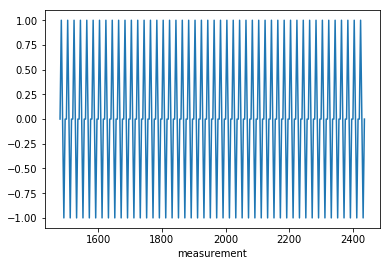

In [25]:
#fig = plt.figure(figsize = [16,12])
scale_hor = df_hor.bk_dev_dI/df_hor.bk_dev_scale_factor/start_current_horizontal
(scale_hor).plot()

The scale was also calculated, let's checi if it is the same here too
Thus the following plot should be a consttant 1

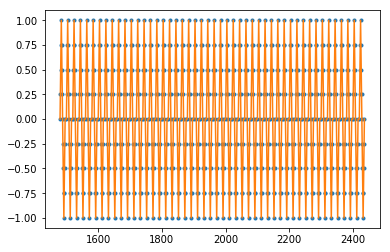

In [26]:
plt.plot(df_hor.measurement, scale_hor, '.' ,
         df_hor.measurement, df_hor.relative_step)

In [27]:
assert(
    (
        ((scale_hor - df_hor.relative_step) < 1e-10) == True
    ).all()
)

<h4> Vertical mode </h4>
Maxima should be at -1, 1

One can see that the whole plot is not fully periodic. I do not yet understand why.
I exepcted that the checks further down fail, but this is not the case ...

In [28]:
df_vert = table_meas_w_ref.loc[table_meas_w_ref.steerer_type == 'vertical',:]

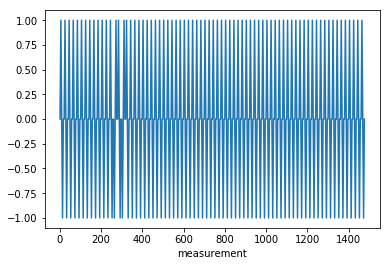

In [29]:
#fig = plt.figure(figsize = [16,12])
scale_vert = df_vert.bk_dev_dI/df_vert.bk_dev_scale_factor/start_current_vertical
scale_vert.plot()

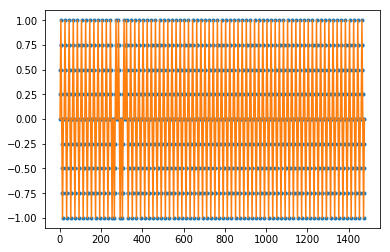

In [30]:
plt.plot(df_vert.measurement, scale_vert, '.' ,
         df_vert.measurement, df_vert.relative_step)

In [31]:
assert(
    (
        ((scale_vert - df_vert.relative_step) < 1e-10) == True
    ).all()
)

<h3> First plots of the gain matrix </h3>

* Attemt to sort the steeres by position
* Should be only made after the analysis has been made

In [32]:
meas_ref_s = meas_ref.sort_values(by='steerer_pos')
table_meas_w_ref_s = table_meas_w_ref.sort_values(by='steerer_pos')

In [33]:
gy_all = np.array(meas_ref_s.bpm_gy.tolist(), dtype=np.float_)
gx_all = np.array(meas_ref_s.bpm_gx.tolist(), dtype=np.float_)

In [34]:
gx_all.shape

(122, 109)

In [35]:
meas_ref.head()

,bk_dev_dI,sc_sel_dev_readback,bpm_gy,dt,bpm_y_diff,bpm_x_scale,relative_step,ramp_index,bk_dev_scale_factor,bk_dev_current_offset,...,steerer_pos,bpm_waveform_y_pos,sc_selected,I_rounded,bpm_ox,sc_sel_dev_setpoint,bpm_y_ref,bk_dev_mode,bpm_x_ref,bpm_oy
sc_selected,,,,,,,,,,,,,,,,,,,,,
hs1pd1r,-2.040851e-19,-0.184779,"[-0.7193679248015359, -0.6708045982981806, -0....",NaN,NaN,NaN,-8.163405e-18,8.0,9.426119,-0.184891,...,1.0,"[0.17613491284466914, 0.24529850578584564, 0.0...",hs1pd1r,-0.184891,"[0.012266271223348717, -0.00535494480698955, 0...",-0.184891,NaN,store_data,NaN,"[0.17613491284466942, 0.24529850578584592, 0.0..."
hs1pd2r,2.040851e-19,-0.095480,"[-0.5952333197326531, -0.5244531399592818, -0....",NaN,NaN,NaN,6.530724e-18,8.0,8.919971,-0.096542,...,2.0,"[0.20670634551930148, 0.2734464837270221, 0.08...",hs1pd2r,-0.096542,"[0.10717593919209699, -0.07419901075367948, -0...",-0.096542,NaN,store_data,NaN,"[0.2067063455193013, 0.27344648372702196, 0.08..."
hs1pd3r,1.632681e-18,0.109031,"[0.42171965006160106, 0.2959808686044084, 0.15...",NaN,NaN,NaN,3.265362e-17,8.0,13.158142,0.107637,...,3.0,"[0.1975061932904412, 0.2629179192738971, 0.078...",hs1pd3r,0.107637,"[0.12883444390257348, -0.15793385967371318, -0...",0.107637,NaN,store_data,NaN,"[0.19750619329044114, 0.262917919273897, 0.078..."
hs1pd4r,2.040851e-19,0.099225,"[0.45030766566085234, 0.4290071755984276, 0.28...",NaN,NaN,NaN,1.142877e-17,8.0,9.321965,0.099602,...,4.0,"[0.20216461183363973, 0.26644539227481623, 0.0...",hs1pd4r,0.099602,"[0.2164019416047787, -0.23178639873621026, -0....",0.099602,NaN,store_data,NaN,"[0.20216461183363993, 0.26644539227481634, 0.0..."
hs1pd5r,0.000000e+00,-0.102790,"[-0.20143178712116078, -0.15555445661730433, -...",NaN,NaN,NaN,0.000000e+00,8.0,11.377503,-0.103353,...,5.0,"[0.19806269030330884, 0.2631243617141545, 0.07...",hs1pd5r,-0.103353,"[0.1994557099871308, -0.2544771156479765, -0.3...",-0.103353,NaN,store_data,NaN,"[0.19806269030330878, 0.2631243617141543, 0.07..."


In [36]:
indices =  np.arange(gx_all.shape[0])
ds = table_agg.bpm_waveform_ds.iat[0]
DS, Indices = np.meshgrid(ds, indices)

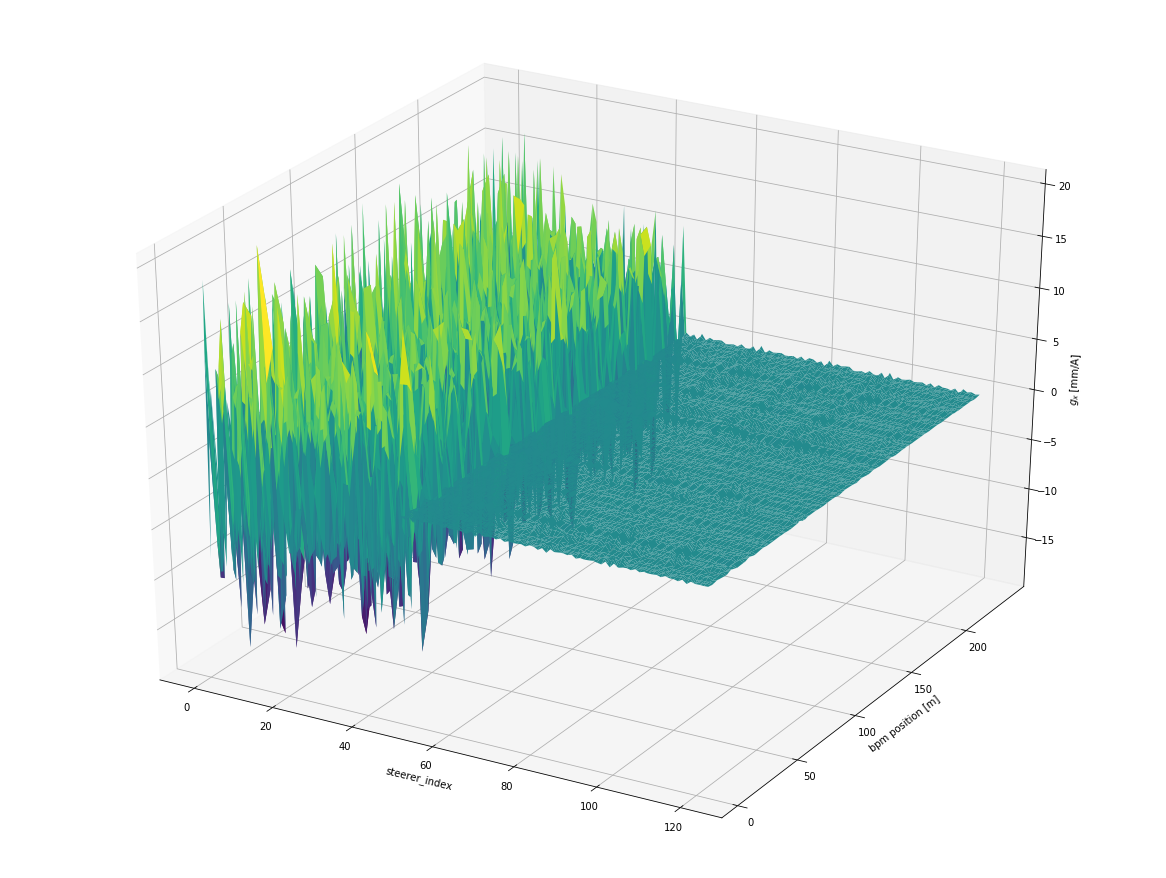

In [37]:
savename = os.path.join(path, 'response_matrix_x.png')
fig = plt.figure(figsize=[16,12])
ax = Axes3D(fig)
ax.plot_surface(Indices, DS, gx_all, rstride=1, cstride=1, cmap=cm.viridis)
ax.set_xlabel('steerer_index')
ax.set_ylabel('bpm position [m]')
ax.set_zlabel('$g_x$ [mm/A]')
fig.savefig(savename, dpi=100)

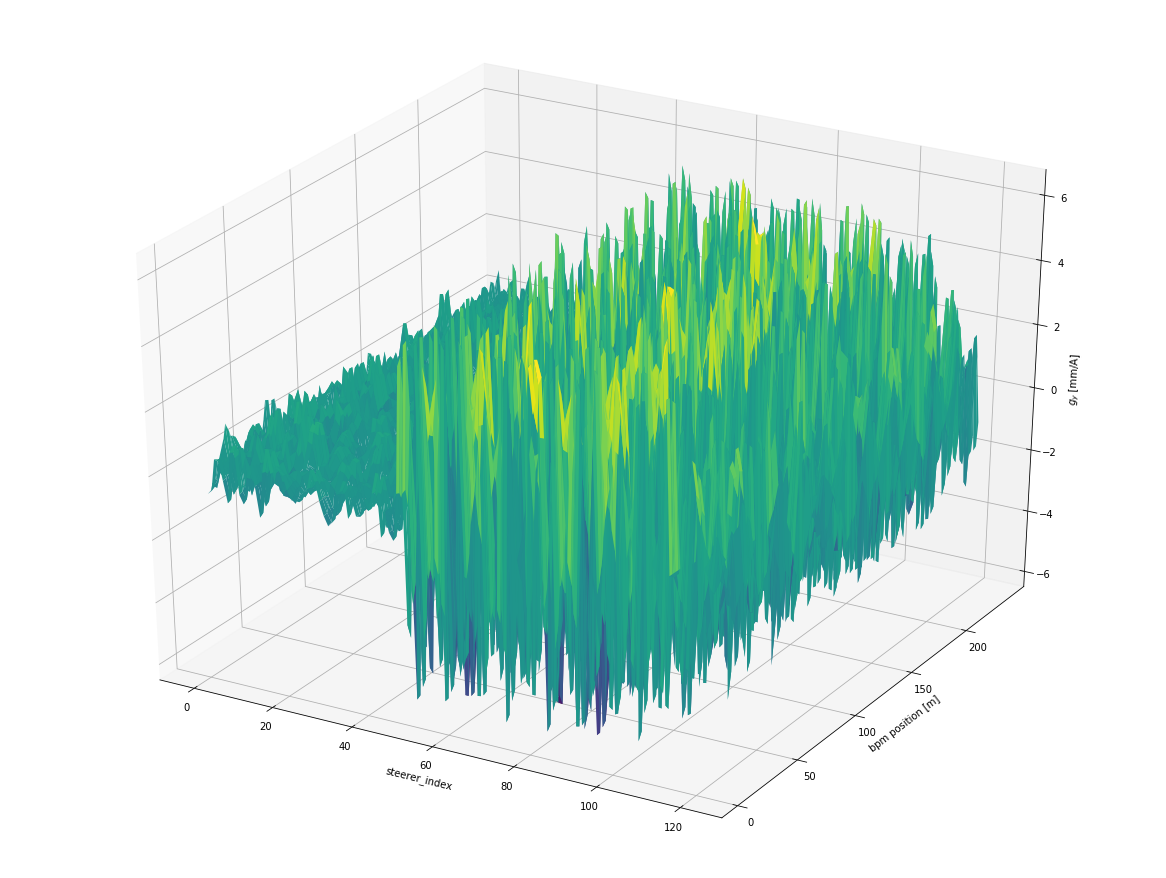

In [38]:
savename = os.path.join(path, 'response_matrix_y.png')
fig = plt.figure(figsize=[16,12])
ax = Axes3D(fig)
ax.plot_surface(Indices, DS, gy_all, rstride=1, cstride=1, cmap=cm.viridis)
ax.set_xlabel('steerer_index')
ax.set_ylabel('bpm position [m]')
ax.set_zlabel('$g_y$ [mm/A]')
fig.savefig(savename, dpi=100)

<h2> First tries to analyse the offsets of the steerers </h2>

The offset of the measurement data to the interpolated line is added to the data 

In [40]:
def add_steerer_scale(df, column_name='sc_selected', copy=True):
    if copy:
        df = df.copy()

    df.bpm_x_diff = df.bpm_waveform_x_pos - df.bpm_x_ref
    df.bpm_y_diff = df.bpm_waveform_y_pos - df.bpm_y_ref
    
    grp = df.groupby(by='sc_selected')
    for steerer_name, index in grp.groups.items():
        sel = df.loc[index,:]
        sel_ri = sel.loc[sel.ramp_index == 4,:]
        assert(sel_ri.shape[0] == 1)
        
        # scale for the x factor
        s_x = sel_ri.bpm_waveform_x_pos.iat[0]
        # scale for the y factor
        s_y = sel_ri.bpm_waveform_y_pos.iat[0]
        
        li = len(index)
        ss_x = pd.Series(index=index, data=[s_x] * li, dtype=np.object_)
        ss_y = pd.Series(index=index, data=[s_y] * li, dtype=np.object_)
            
        df.loc[index, 'bpm_x_scale'] = ss_x
        df.loc[index, 'bpm_y_scale'] = ss_y
        
    return df
        #break  
    

In [41]:
table_meas_w_ref = add_steerer_scale(table_meas_w_ref)

In [42]:
table_meas_w_ref;

excluded_steerers = ['hs4p1d3r',
                     'vs2p2t1r',
                     'vs3p2t8r'
                     #'hs1pd4r'
                    ]

Select only the columns required for further processing.
This makes the further treatment of the tables considerably faster

In [43]:
cols = [
    'time', 'sc_selected', 'ramp_index', 
    'bpm_x_diff', 'bpm_y_diff',  
    'bpm_x_scale', 'bpm_y_scale', 
    'bpm_x_ref', 'bpm_y_ref', 
    'bpm_waveform_ds', 'measurement',
    'relative_step',
    'steerer_pos'
]
tt2 = table_meas_w_ref.sort_values(by='steerer_pos').loc[:, cols]
#tt2 = tt2.loc[~tt2.sc_selected.isin(excluded_steerers),:]
#table_meas_w_ref.steerer_pos

In [44]:
tt2.sc_selected.iat[16]

'hs1pd1r'

In [45]:
steerer_sel = 'hs1pd1r'

importlib.reload(dfg)
#df_sel = dfg.df_with_vectors_amax(tt2, 'sc_selected')
# df_sel = table_meas_w_ref.loc[table_meas_w_ref.sc_selected==steerer_sel,:]
df_sel = tt2.loc[(tt2.relative_step.abs() < .3) & (tt2.relative_step.abs() > 1e-3), :]
dx_one = np.array(df_sel.bpm_x_diff.tolist(), dtype=np.float_)
dy_one = np.array(df_sel.bpm_y_diff.tolist(), dtype=np.float_)
dx_s   = np.array(df_sel.bpm_x_scale.tolist(), dtype=np.float_)
dy_s   = np.array(df_sel.bpm_y_scale.tolist(), dtype=np.float_)

In [46]:
df_sel.shape

(488, 13)

Beam position monitors which are currently considered to give faulty results

In [47]:
#ds = table_meas_w_ref.bpm_waveform_ds.iat[0]
bpm_indices = np.ones(table_meas_w_ref.bpm_waveform_ds.iat[0].shape, np.bool_)

# Needs to be rechecked
# TZesting if scanning over all data
bpm_indices[65] = 0
#bpm_indices[60:80] = 0


bpm_indices[93] = 0


bpm_indices[41] = 0
bpm_indices[8] = 0
bpm_indices[71] = 0
bpm_indices[82] = 0
bpm_indices[64] = 0
np.array(table_meas_w_ref.bpm_waveform_names.iat[0])[~bpm_indices]

array(['BPMZ7T1R', 'BPMZ6D4R', 'BPMZ2D6R', 'BPMZ3D6R', 'BPMZ3T6R',
       'BPMZ6D7R', 'BPMZ3D8R'], dtype='<U9')

In [48]:
def data_only_with_working_bpms(data, working_bpms=bpm_indices):
    ndata = data[:, working_bpms]
    return ndata

In [49]:
dx_s_one = dx_one/dx_s
dy_s_one = dy_one/dy_s

indices =  np.arange(len(df_sel.sc_selected))

ds = table_meas_w_ref.bpm_waveform_ds.iat[0]
ds = np.arange(len(ds))

if True:
    ds = ds[bpm_indices]
    dx_s_one, dy_s_one = map(data_only_with_working_bpms, [dx_s_one, dy_s_one])
                  
# dx_s_one = dx_s_one[:,bpm_indices]
# dy_s_one = dy_s_one[:,bpm_indices]
                     
s, e = 0, 1000
#s, e = 64, 70
                     #s, e = 58, 68
ds = ds[s:e]
dx_s_one = dx_s_one[:,s:e]
dy_s_one = dy_s_one[:,s:e]
DS, Indices = np.meshgrid(ds, indices)

In [50]:
table_meas_w_ref.bpm_waveform_ds;

In [51]:
Indices.shape, DS.shape, dx_s_one.shape

((488, 102), (488, 102), (488, 102))

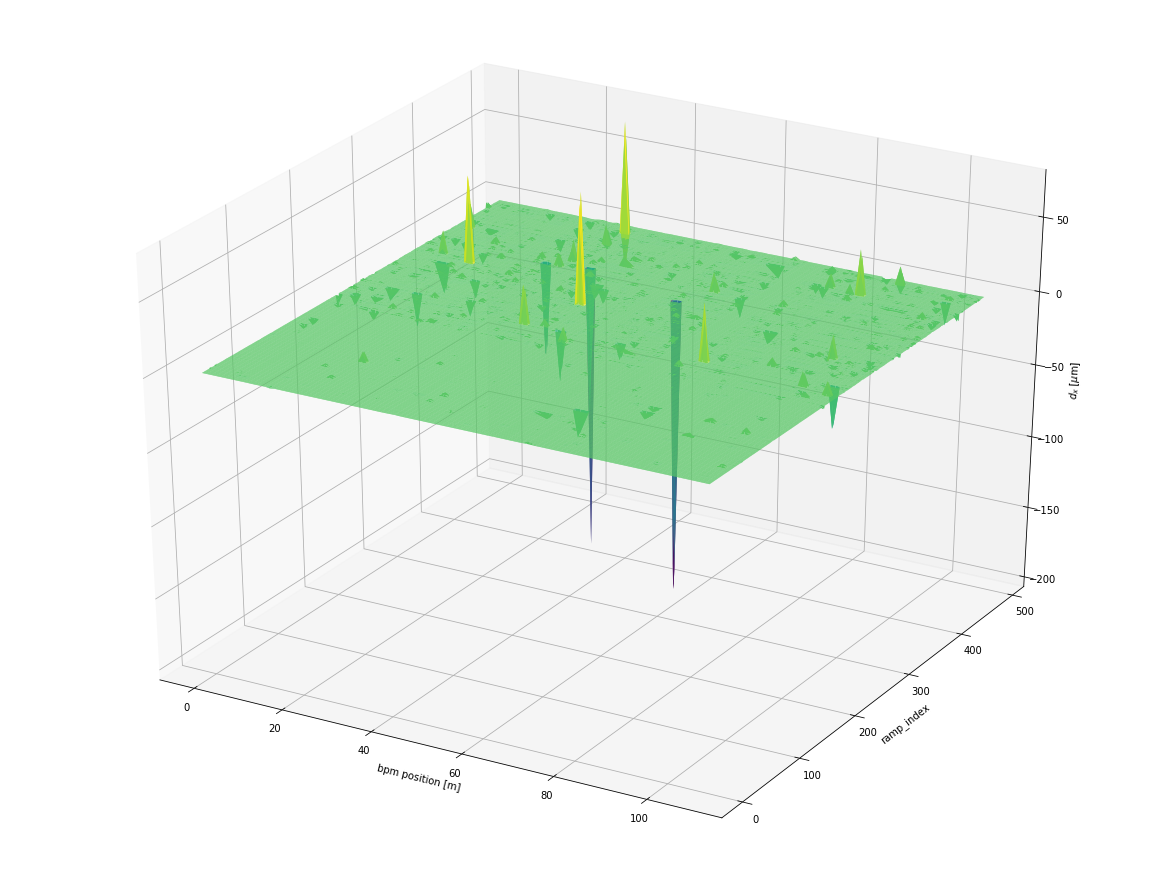

In [52]:
savename = os.path.join(path, 'steerer_inhomogeneity_{}_x.png'.format(steerer_sel))
fig = plt.figure(figsize=[16,12])
ax = Axes3D(fig)
ax.plot_surface(DS, Indices, dx_s_one, rstride=1, cstride=1, cmap=cm.viridis)
ax.set_ylabel('ramp_index')
ax.set_xlabel('bpm position [m]')
ax.set_zlabel('$d_x$ [$\mu$m]')
fig.savefig(savename, dpi=100)

In [53]:
np.absolute(dx_s_one).argmax(axis=0)

array([214, 382, 429, 412, 380, 303, 346, 378, 324, 303, 194, 391, 337,
       241,   1, 303, 360,  64, 303, 324, 193, 426,  89, 256, 303, 369,
       223, 109, 368, 387, 469, 303,  19, 391, 378, 318, 279, 321, 232,
       345, 324, 299,  40,  56, 281, 232, 364, 418, 214, 262, 435, 159,
        55, 477, 469, 425, 345, 472, 232, 193, 380, 217, 464, 269, 378,
       361,  84,  59, 102,  49, 214, 478, 440, 233, 436, 442, 320, 429,
       479, 435, 422, 436, 173, 407, 254, 477, 447,  80, 396, 468, 294,
       294, 194, 224, 215, 110, 458, 482, 236, 217, 371, 439])

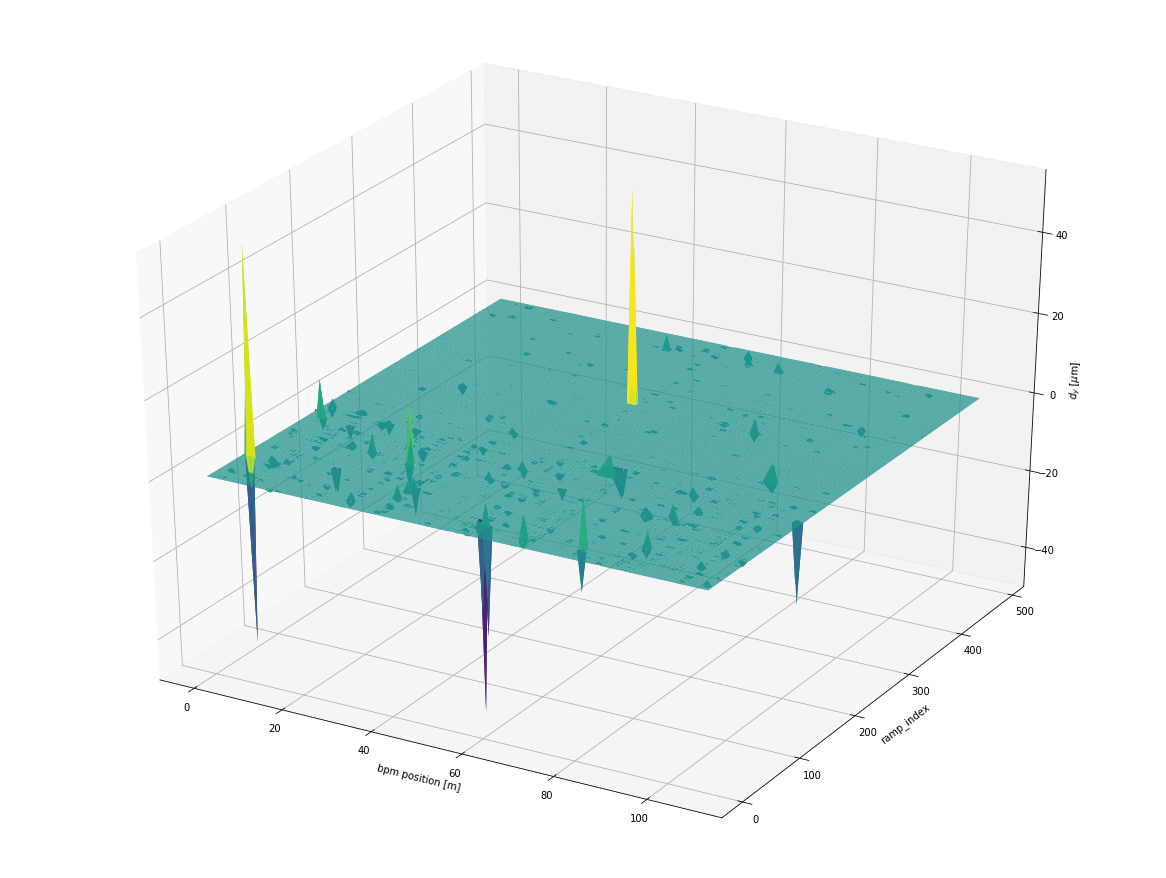

In [54]:
savename = os.path.join(path, 'steerer_inhomogeneity_{}_y.png'.format(steerer_sel))
fig = plt.figure(figsize=[16,12])
ax = Axes3D(fig)
ax.plot_surface(DS, Indices, dy_s_one, rstride=1, cstride=1, cmap=cm.viridis)
ax.set_ylabel('ramp_index')
ax.set_xlabel('bpm position [m]')
ax.set_zlabel('$d_y$ [$\mu$m]')
fig.savefig(savename, dpi=100)

In [55]:
table_meas_w_ref.columns

Index(['time', 'bpm_x_ref', 'bpm_y_ref', 'bpm_x_diff', 'bpm_y_diff',
       'steerer_mode', 'steerer_pos', 'I_rounded', 'bk_dev_dI',
       'bk_dev_scale_factor', 'bk_dev_current_offset', 'sc_sel_dev_setpoint',
       'sc_sel_dev_readback', 'ramp_index', 'dt', 'bpm_x_scale', 'bpm_y_scale',
       'relative_step', 'bpm_waveform_names', 'bpm_waveform_x_pos',
       'bpm_waveform_y_pos', 'bpm_waveform_ds', 'steerer_type', 'sc_selected',
       'bk_dev_mode', 'measurement'],
      dtype='object')

In [56]:
def prepare_offset_from_fit(df, coor, scale = 1000, mode = 'rscale'):
    '''
    
    Args:
        scale: scale the value (default 1000 corresponds from mm to um)
    '''
    if coor == 'x':
        diff = df.bpm_x_diff
        bscale = df.bpm_x_scale
        refv = df.bpm_x_ref

    elif coor == 'y':
        diff = df.bpm_y_diff
        bscale = df.bpm_y_scale
        refv = df.bpm_y_ref
     
    else:
        raise AssertionError(f'Coordinate {coor} unknown')

    offset = np.array(diff.tolist(), dtype=np.float_)
    gain = np.array(bscale.tolist(), dtype=np.float_)
    ref = np.array(refv.tolist(), dtype=np.float_)
    
    del diff, bscale, refv
    # The "polarity" of some steeres could be changed. Then they would
    # kick to the same side of the orbit
    sign = np.sign(gain)

    
    if mode == 'offset':
        # mm to um
        res = offset * scale
    elif mode == 'offset_sign':
        # Just scale by sign ... 
        res = offset * scale
        res = res * sign
    elif mode == 'rscale':
        # Need to fix divison by zero
        ref < 1e-16
        res = offset / ref
    return res


In [57]:
if False:
    df_sel = dfg.df_with_vectors_max(table_meas_w_ref, 'sc_selected')

    sdx_all = prepare_offset_from_fit(df_sel, 'x')
    sdy_all = prepare_offset_from_fit(df_sel, 'y')
    indices =  df_sel.measurement
else:
    sdx_all = prepare_offset_from_fit(table_meas_w_ref, 'x')
    sdy_all = prepare_offset_from_fit(table_meas_w_ref, 'y')
    indices = table_meas_w_ref.measurement

val = 10
# sdx_all[np.absolute(sdx_all>val)] = 0


In [58]:
df_sel.bpm_x_ref

measurement
1489    [0.2437351654882613, -0.3177023569163616, -0.4...
1495    [0.2437351654882613, -0.3177023569163616, -0.4...
1487    [-0.21920262304157273, 0.3069924673023945, 0.5...
1481    [-0.21920262304157273, 0.3069924673023945, 0.5...
1969    [0.020084666664575132, 0.11329335985179097, 0....
1961    [0.19426721171961556, -0.2616913813591428, -0....
1967    [0.19426721171961556, -0.2616913813591428, -0....
1975    [0.020084666664575132, 0.11329335985179097, 0....
2095    [-0.18845820302569355, 0.07192939383303396, 0....
2089    [-0.18845820302569355, 0.07192939383303396, 0....
2087    [0.4461270908308405, -0.3877971131804603, -0.6...
2081    [0.4461270908308405, -0.3877971131804603, -0.6...
2215    [0.261226368429177, -0.42664633692424947, -0.6...
2201    [0.1715775147803821, -0.03692646054817833, -0....
2207    [0.1715775147803821, -0.03692646054817833, -0....
2209    [0.261226368429177, -0.42664633692424947, -0.6...
2327    [-0.0947129356982398, 0.03681836941505756, 0.1...
23

In [59]:
df_sel = df_sel.sort_values(by='steerer_pos')

ds = df_sel.bpm_waveform_ds.iat[0]

if True:
    sdx_all = data_only_with_working_bpms(sdx_all)
    sdy_all = data_only_with_working_bpms(sdy_all)
    ds = ds[bpm_indices]
DS, Indices = np.meshgrid(ds, indices)

In [60]:
sdx_all.shape, DS.shape, Indices.shape

((2074, 102), (2074, 102), (2074, 102))

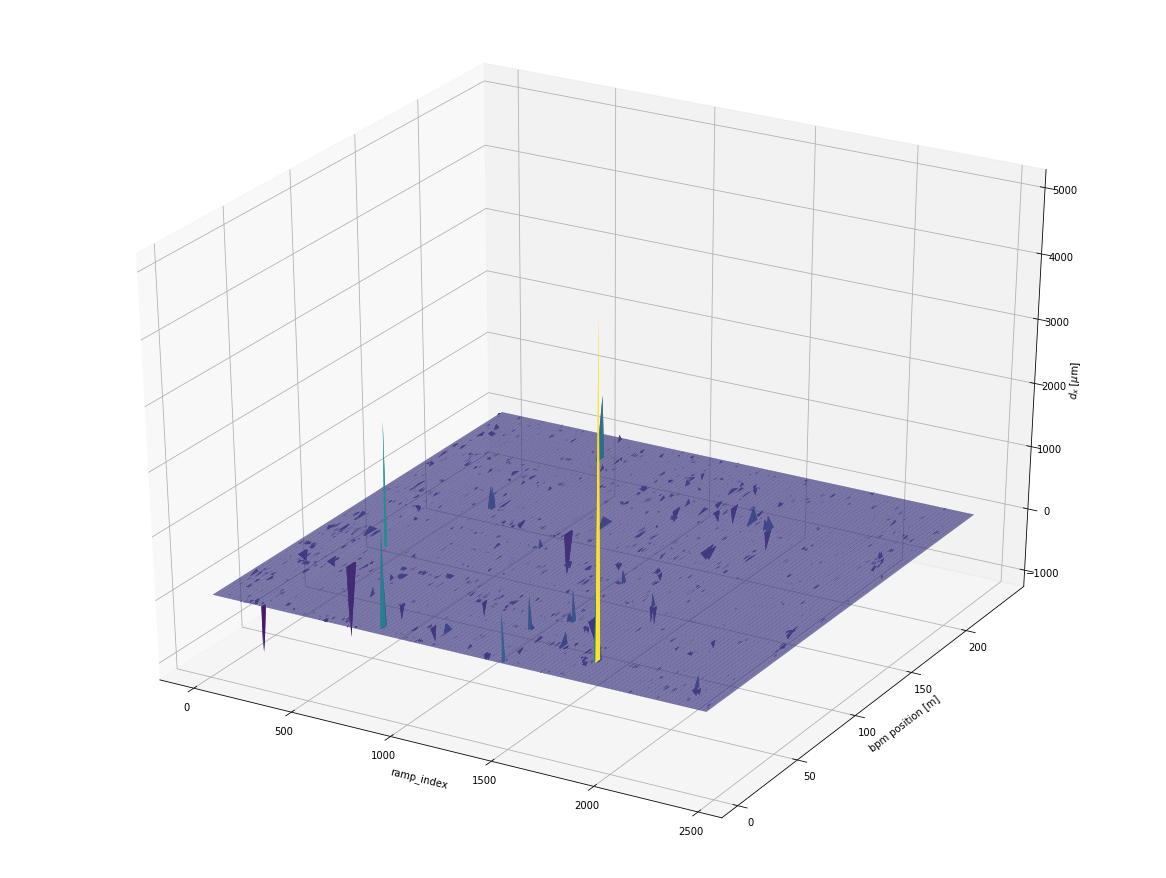

In [61]:
savename = os.path.join(path, 'steerer_inhomogeneity_all_x.png')
fig = plt.figure(figsize=[16,12])
ax = Axes3D(fig)
ax.plot_surface(Indices, DS, sdx_all, rstride=1, cstride=1, cmap=cm.viridis)
ax.set_xlabel('ramp_index')
ax.set_ylabel('bpm position [m]')
ax.set_zlabel('$d_x$ [$\mu$m]')
fig.savefig(savename, dpi=100)

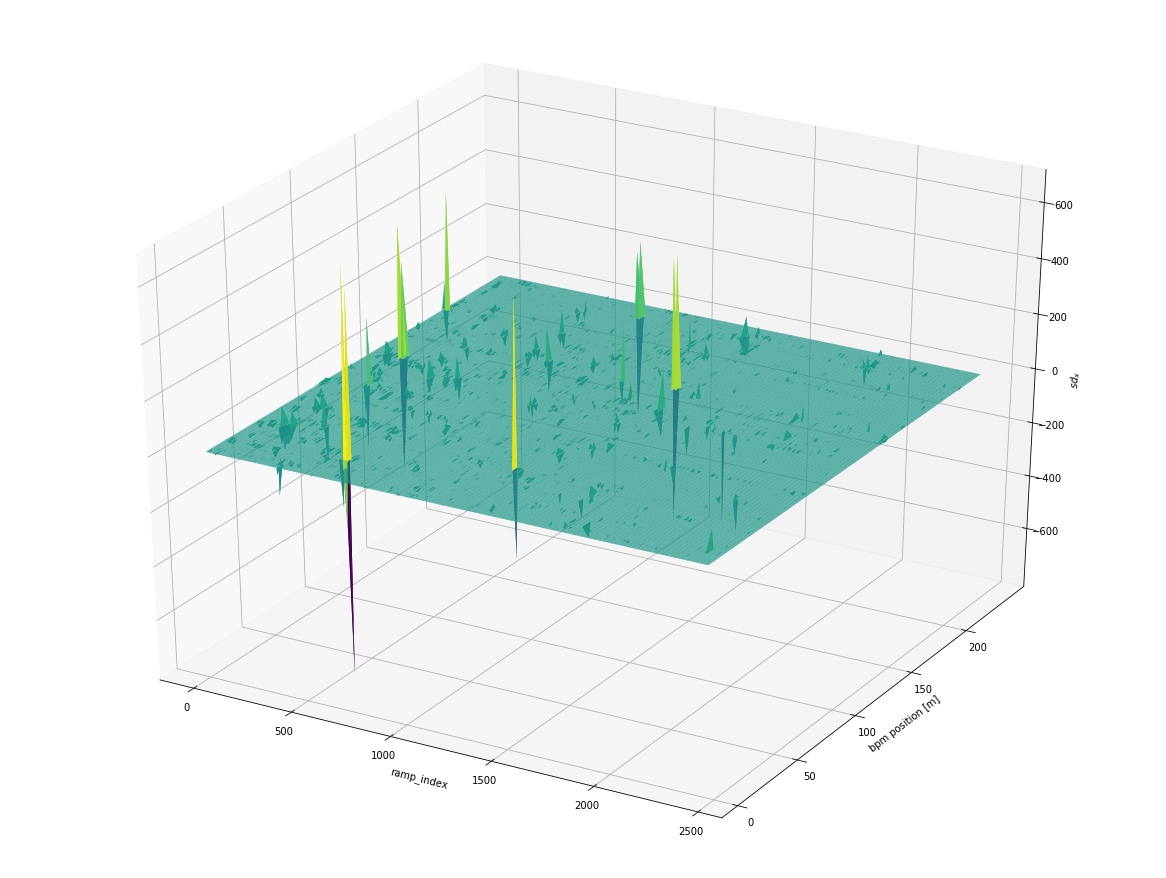

In [62]:
savename = os.path.join(path, 'steerer_inhomogeneity_all_y.png')
fig = plt.figure(figsize=[16,12])
ax = Axes3D(fig)
ax.plot_surface(Indices, DS, sdy_all, rstride=1, cstride=1, cmap=cm.viridis)
ax.set_xlabel('ramp_index')
ax.set_ylabel('bpm position [m]')
ax.set_zlabel('$sd_x$')
fig.savefig(savename, dpi=100)

In [63]:
mlab.surf(Indices, DS, sdy_all)

AttributeError: module 'matplotlib.mlab' has no attribute 'surf'